In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
import glob
import cv2
from tqdm import tqdm

In [4]:
def imshow(title = "Image", image = None, size = 10):
    w= image.shape[0]
    h=image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

In [5]:
IMG_SIZE = 768
WIDTH = 1147

image_paths = glob.glob(r"C:\Files\Araneus diadematus\Missing leg study\Missing leg treatment\*.jpg")
allImages = []
#resizing and normalizing every image
for imgFile in tqdm(image_paths, total=len(image_paths)):
  img = cv2. imread(imgFile)
  img = cv2.resize(img, (WIDTH, IMG_SIZE))
  img = img/255.0
  allImages.append(img)



images = np.array(allImages)
print(images.shape)

100%|██████████| 69/69 [00:06<00:00, 11.35it/s]


(69, 768, 1147, 3)


In [6]:
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray((img * 255).astype(np.uint8)) for img in images],
}

In [7]:
from datasets import Dataset
# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


dataset

c:\Users\adamain\.conda\envs\imgid\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['image'],
    num_rows: 69
})

In [ ]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [9]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["image"])
    
    # Convert the image to RGB format
    #image = image.convert("RGB") #This line was added to make sure images are read in expected format

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [10]:
import torch
import numpy as np
import cv2
from segment_anything import sam_model_registry, SamPredictor

# Load SAM model
# sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b.pth")  # Download the .pth file first
# sam.to("cuda" if torch.cuda.is_available() else "cpu")
# # Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

c:\Users\adamain\.conda\envs\imgid\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [11]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [12]:
from torch.utils.data import DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False, collate_fn=collate_fn)


here

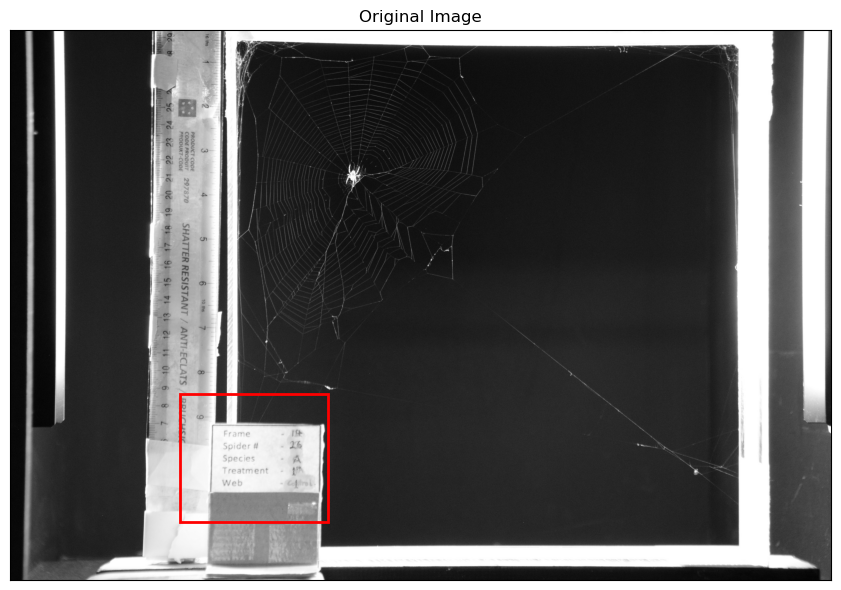

In [31]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import SamModel, SamConfig, SamProcessor
import torch

# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
#my_mito_model.load_state_dict(torch.load()) #may need to change the file here
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

# Path to your new image
image_path = r"C:\Files\Araneus diadematus\Missing leg study\Missing leg treatment\26 - 1.JPG"
# Load and preprocess the image
def load_and_preprocess(image_path):
    # Read as grayscale but convert to RGB-like format for SAM
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Handle 16-bit TIFF normalization if needed
    if img.dtype == np.uint16:
        img = cv2.convertScaleAbs(img, alpha=(255.0/65535.0))
    
    # Convert to 3-channel "RGB" by stacking grayscale channels
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img_rgb, img  # Return both RGB and original grayscale

# Load your image
test_image, original_grayscale = load_and_preprocess(image_path)
#function to find the coordinates of the box- restricted to the bottom left quadrant of the screen
def auto_detect_prompt(gray_image, box_width=700, box_height=600, step=20):
    height, width = gray_image.shape
    best_score = float('inf')  # Lower is better: dark-on-bright
    best_box = None

    # Search bottom-left quadrant
    x_max = max(0, width // 2 - box_width)
    y_max = max(0, height - box_height)

    for y in range(height // 2, y_max, step):
        for x in range(0, x_max, step):
            patch = gray_image[y:y + box_height, x:x + box_width]
            if patch.shape[0] != box_height or patch.shape[1] != box_width:
                continue

            # Focus on middle horizontal band (to ignore border noise)
            band = patch[box_height // 4: 3 * box_height // 4, :]

            # Bright background? (we want high average)
            bg_mean = np.mean(band)

            # Detect dark text by thresholding
            _, binary = cv2.threshold(band, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            text_score = np.mean(binary == 0)  # fraction of black pixels

            # Invert score: we want high brightness and some dark text
            score = -bg_mean + (text_score * 100)

            if score < best_score:
                best_score = score
                best_box = [x, y, x + box_width, y + box_height]

    if best_box:
        return best_box
    else:
        return [0, height // 2, box_width, height]

prompt = auto_detect_prompt(original_grayscale)

# Prepare inputs for SAM model
inputs = processor(
    Image.fromarray(test_image),  # Convert to PIL Image
    input_boxes=[[prompt]],       # Use detected bounding box
    return_tensors="pt"
).to(device)

# Run inference
my_mito_model.eval()
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# Process outputs
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
medsam_seg = (medsam_seg_prob > 0.5).float().cpu().numpy().squeeze()
medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()

# Visualization with bounding box overlay
fig, axes = plt.subplots(1, 1, figsize=(18, 6))

# Original Image
axes.imshow(original_grayscale, cmap='gray')
axes.set_title("Original Image")
axes.add_patch(plt.Rectangle((prompt[0], prompt[1]),
                              prompt[2]-prompt[0],
                              prompt[3]-prompt[1],
                              fill=False, edgecolor='red', linewidth=2))

# Formatting

axes.set_xticks([])
axes.set_yticks([])

plt.tight_layout()
plt.show()


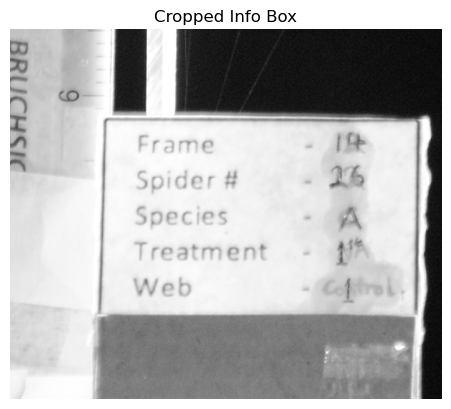

In [42]:
#Displays the cropped box
#Getting some kind of image overlay to find the exact area containing the text would be useful as suggested by Gabriel
x1, y1, x2, y2 = prompt
cropped_image = original_grayscale[y1:y2, x1:x2]
cv2.imwrite("C:\Files\Araneus diadematus\Processed Images\processedcropped.jpg", cropped_image)
plt.imshow(cropped_image, cmap='gray')
plt.title("Cropped Info Box")
plt.axis('off')
plt.show()


In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def crop_to_text_region(img, template_img=None, output_path=None, show_steps=True):
    """
    Crop an image to focus on the text region using template matching if a template is provided,
    otherwise fall back to white box detection.
    
    Args:
        img: Input image as numpy.ndarray (can be grayscale or color)
        template_img: Template image (your ideal cropped region) for template matching
        output_path: Path to save the cropped image (optional)
        show_steps: Whether to display intermediate processing steps
    
    Returns:
        Cropped image as numpy array (same format as input)
    """
    
    # Validate input
    if not isinstance(img, np.ndarray):
        raise ValueError("Input must be a numpy.ndarray")
    
    # Handle both grayscale and color images
    if len(img.shape) == 2:
        is_grayscale = True
        original = img.copy()
        gray = img.copy()
    elif len(img.shape) == 3 and img.shape[2] == 3:
        is_grayscale = False
        original = img.copy()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Input image must be either grayscale (2D) or 3-channel color image")
    
    height, width = gray.shape
    
    if show_steps:
        plt.figure(figsize=(20, 15))
        plt.subplot(3, 4, 1)
        if is_grayscale:
            plt.imshow(original, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')
    
    # Use template matching if template is provided
    if template_img is not None:
        crop_x1, crop_y1, crop_x2, crop_y2 = template_match_crop(
            gray, template_img, show_steps, original, is_grayscale
        )
    else:
        # Fall back to white box detection
        crop_x1, crop_y1, crop_x2, crop_y2 = white_box_detection_crop(
            gray, show_steps, original, is_grayscale, width, height
        )
    
    # Crop the image
    cropped = original[crop_y1:crop_y2, crop_x1:crop_x2]
    
    if show_steps:
        plt.subplot(3, 4, 5)
        if is_grayscale:
            plt.imshow(cropped, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        plt.title('Final Cropped Result')
        plt.axis('off')
        
        # Show original with crop overlay
        plt.subplot(3, 4, 6)
        overlay = original.copy()
        if not is_grayscale:
            overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
        else:
            overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2RGB)
        
        cv2.rectangle(overlay, (crop_x1, crop_y1), (crop_x2, crop_y2), (255, 0, 0), 3)
        plt.imshow(overlay)
        plt.title('Original with Crop Region')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Original size: {width}x{height}")
        print(f"Final crop coordinates: ({crop_x1}, {crop_y1}) to ({crop_x2}, {crop_y2})")
        print(f"Cropped size: {crop_x2-crop_x1}x{crop_y2-crop_y1}")
    
    if output_path:
        cv2.imwrite(output_path, cropped)
        print(f"Cropped image saved to {output_path}")
    
    return cropped

def template_match_crop(gray, template_img, show_steps, original, is_grayscale):
    """
    Use template matching to find the region that matches the template.
    """
    # Convert template to grayscale if needed
    if len(template_img.shape) == 3:
        template_gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
    else:
        template_gray = template_img.copy()
    
    template_h, template_w = template_gray.shape
    
    if show_steps:
        plt.subplot(3, 4, 2)
        plt.imshow(template_gray, cmap='gray')
        plt.title(f'Template\n{template_w}x{template_h}')
        plt.axis('off')
    
    # Try multiple template matching methods
    methods = [
        ('TM_CCOEFF_NORMED', cv2.TM_CCOEFF_NORMED),
        ('TM_CCORR_NORMED', cv2.TM_CCORR_NORMED),
        ('TM_SQDIFF_NORMED', cv2.TM_SQDIFF_NORMED)
    ]
    
    best_match = None
    best_confidence = -1
    best_method = None
    
    for method_name, method in methods:
        result = cv2.matchTemplate(gray, template_gray, method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        
        if method == cv2.TM_SQDIFF_NORMED:
            confidence = 1 - min_val
            match_loc = min_loc
        else:
            confidence = max_val
            match_loc = max_loc
        
        if confidence > best_confidence:
            best_confidence = confidence
            best_match = match_loc
            best_method = method_name
    
    if show_steps:
        plt.subplot(3, 4, 3)
        if best_method == 'TM_SQDIFF_NORMED':
            result = cv2.matchTemplate(gray, template_gray, cv2.TM_SQDIFF_NORMED)
        else:
            result = cv2.matchTemplate(gray, template_gray, cv2.TM_CCOEFF_NORMED)
        plt.imshow(result, cmap='hot')
        plt.title(f'Template Match Result\n{best_method}')
        plt.colorbar()
        plt.axis('off')
    
    # Exact match region (no padding)
    top_left = best_match
    crop_x1, crop_y1 = top_left
    crop_x2 = crop_x1 + template_w
    crop_y2 = crop_y1 + template_h
    
    if show_steps:
        plt.subplot(3, 4, 4)
        match_img = gray.copy()
        match_img = cv2.cvtColor(match_img, cv2.COLOR_GRAY2RGB)
        cv2.rectangle(match_img, top_left, (crop_x2, crop_y2), (0, 255, 0), 2)
        plt.imshow(match_img)
        plt.title(f'Match Found\nConfidence: {best_confidence:.3f}')
        plt.axis('off')
        
        print(f"Template matching - Method: {best_method}, Confidence: {best_confidence:.3f}")
        print(f"Match location: {top_left}")
    
    return crop_x1, crop_y1, crop_x2, crop_y2
    
    # Calculate crop coordinates
    top_left = best_match
    crop_x1, crop_y1 = top_left
    crop_x2 = crop_x1 + template_w
    crop_y2 = crop_y1 + template_h
    
    # Add small padding if there's room
    padding = 5
    crop_x1 = max(0, crop_x1 - padding)
    crop_y1 = max(0, crop_y1 - padding)
    crop_x2 = min(gray.shape[1], crop_x2 + padding)
    crop_y2 = min(gray.shape[0], crop_y2 + padding)
    
    if show_steps:
        plt.subplot(3, 4, 4)
        match_img = gray.copy()
        match_img = cv2.cvtColor(match_img, cv2.COLOR_GRAY2RGB)
        cv2.rectangle(match_img, (crop_x1, crop_y1), (crop_x2, crop_y2), (255, 0, 0), 2)
        cv2.rectangle(match_img, top_left, (top_left[0] + template_w, top_left[1] + template_h), (0, 255, 0), 2)
        plt.imshow(match_img)
        plt.title(f'Match Found\nConfidence: {best_confidence:.3f}\nGreen=exact, Red=with padding')
        plt.axis('off')
        
        print(f"Template matching - Method: {best_method}, Confidence: {best_confidence:.3f}")
        print(f"Match location: {top_left}")
    
    return crop_x1, crop_y1, crop_x2, crop_y2

def white_box_detection_crop(gray, show_steps, original, is_grayscale, width, height):
    """
    Fallback method using white box detection.
    """
    _, white_thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    
    if show_steps:
        plt.subplot(3, 4, 2)
        plt.imshow(white_thresh, cmap='gray')
        plt.title('White Regions (Fallback)')
        plt.axis('off')
    
    contours, _ = cv2.findContours(white_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    candidate_boxes = []
    min_area = (width * height) * 0.05
    max_area = (width * height) * 0.8
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area < area < max_area:
            x, y, w, h = cv2.boundingRect(contour)
            edge_margin = 10
            if (x > edge_margin and y > edge_margin and 
                x + w < width - edge_margin and y + h < height - edge_margin):
                aspect_ratio = w / h
                if 0.8 < aspect_ratio < 4.0:
                    rect_area = w * h
                    rectangularity = area / rect_area
                    if rectangularity > 0.7:
                        candidate_boxes.append({
                            'bbox': (x, y, w, h),
                            'area': area,
                            'rectangularity': rectangularity,
                            'aspect_ratio': aspect_ratio
                        })
    
    if candidate_boxes:
        # Select best box (same logic as before)
        best_box = max(candidate_boxes, key=lambda b: b['rectangularity'])
        x, y, w, h = best_box['bbox']
        
        padding = 5
        crop_x1 = max(0, x - padding)
        crop_y1 = max(0, y - padding)
        crop_x2 = min(width, x + w + padding)
        crop_y2 = min(height, y + h + padding)
    else:
        # Ultimate fallback
        crop_x1, crop_y1, crop_x2, crop_y2 = fallback_crop_coordinates(width, height)
    
    if show_steps:
        plt.subplot(3, 4, 3)
        fallback_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
        cv2.rectangle(fallback_img, (crop_x1, crop_y1), (crop_x2, crop_y2), (255, 0, 0), 2)
        plt.imshow(fallback_img)
        plt.title('Fallback Detection')
        plt.axis('off')
    
    return crop_x1, crop_y1, crop_x2, crop_y2

def crop_with_template_from_path(img, template_path, output_path=None, show_steps=False):
    """
    Convenience function to crop using a template image from file path.
    
    Args:
        img: Input image as numpy.ndarray
        template_path: Path to template image file
        output_path: Path to save the cropped image (optional)
        show_steps: Whether to display intermediate processing steps
    
    Returns:
        Cropped image as numpy array
    """
    template_img = cv2.imread(template_path)
    if template_img is None:
        raise ValueError(f"Could not read template image from {template_path}")
    
    return crop_to_text_region(img, template_img, output_path, show_steps)

def create_template_from_manual_crop(img, x1, y1, x2, y2, template_save_path):
    """
    Create a template by manually cropping a region from an image.
    
    Args:
        img: Input image
        x1, y1: Top-left corner of crop region
        x2, y2: Bottom-right corner of crop region
        template_save_path: Path to save the template image
    
    Returns:
        Template image as numpy array
    """
    template = img[y1:y2, x1:x2]
    cv2.imwrite(template_save_path, template)
    print(f"Template saved to {template_save_path}")
    return template

def fallback_crop_coordinates(width, height):
    """
    Generate fallback crop coordinates when no white box is detected.
    """
    crop_x1 = int(width * 0.1)
    crop_y1 = int(height * 0.4) 
    crop_x2 = int(width * 0.9)
    crop_y2 = int(height * 0.95)
    
    return crop_x1, crop_y1, crop_x2, crop_y2

def center_crop(img, scale=0.6):
    """
    Fallback: crop the center portion of the image.
    """
    if len(img.shape) == 2:
        h, w = img.shape
    else:
        h, w = img.shape[:2]
    
    crop_h = int(h * scale)
    crop_w = int(w * scale)
    
    start_y = (h - crop_h) // 2
    start_x = (w - crop_w) // 2
    
    return img[start_y:start_y + crop_h, start_x:start_x + crop_w]

def crop_with_manual_box(img, x1, y1, x2, y2):
    """
    Crop image with manually specified coordinates.
    """
    return img[y1:y2, x1:x2]

def batch_crop_images(images, template_img=None, output_dir="cropped_images", image_names=None):
    """
    Crop multiple images in batch, optionally using a template.
    
    Args:
        images: List of numpy.ndarray images
        template_img: Optional template image for template matching
        output_dir: Directory to save cropped images
        image_names: Optional list of names for the images (without extension)
    """
    import os
    
    os.makedirs(output_dir, exist_ok=True)
    
    for i, img in enumerate(images):
        try:
            if image_names and i < len(image_names):
                filename = f"{image_names[i]}.jpg"
            else:
                filename = f"cropped_{i+1}.jpg"
            
            output_path = os.path.join(output_dir, filename)
            cropped = crop_to_text_region(img, template_img, output_path)
            print(f"Successfully processed image {i+1}")
        except Exception as e:
            print(f"Error processing image {i+1}: {str(e)}")

def load_image_from_path(image_path):
    """
    Helper function to load an image from file path.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image from {image_path}")
    return img

Template matching - Method: TM_CCORR_NORMED, Confidence: 0.962
Match location: (88, 142)


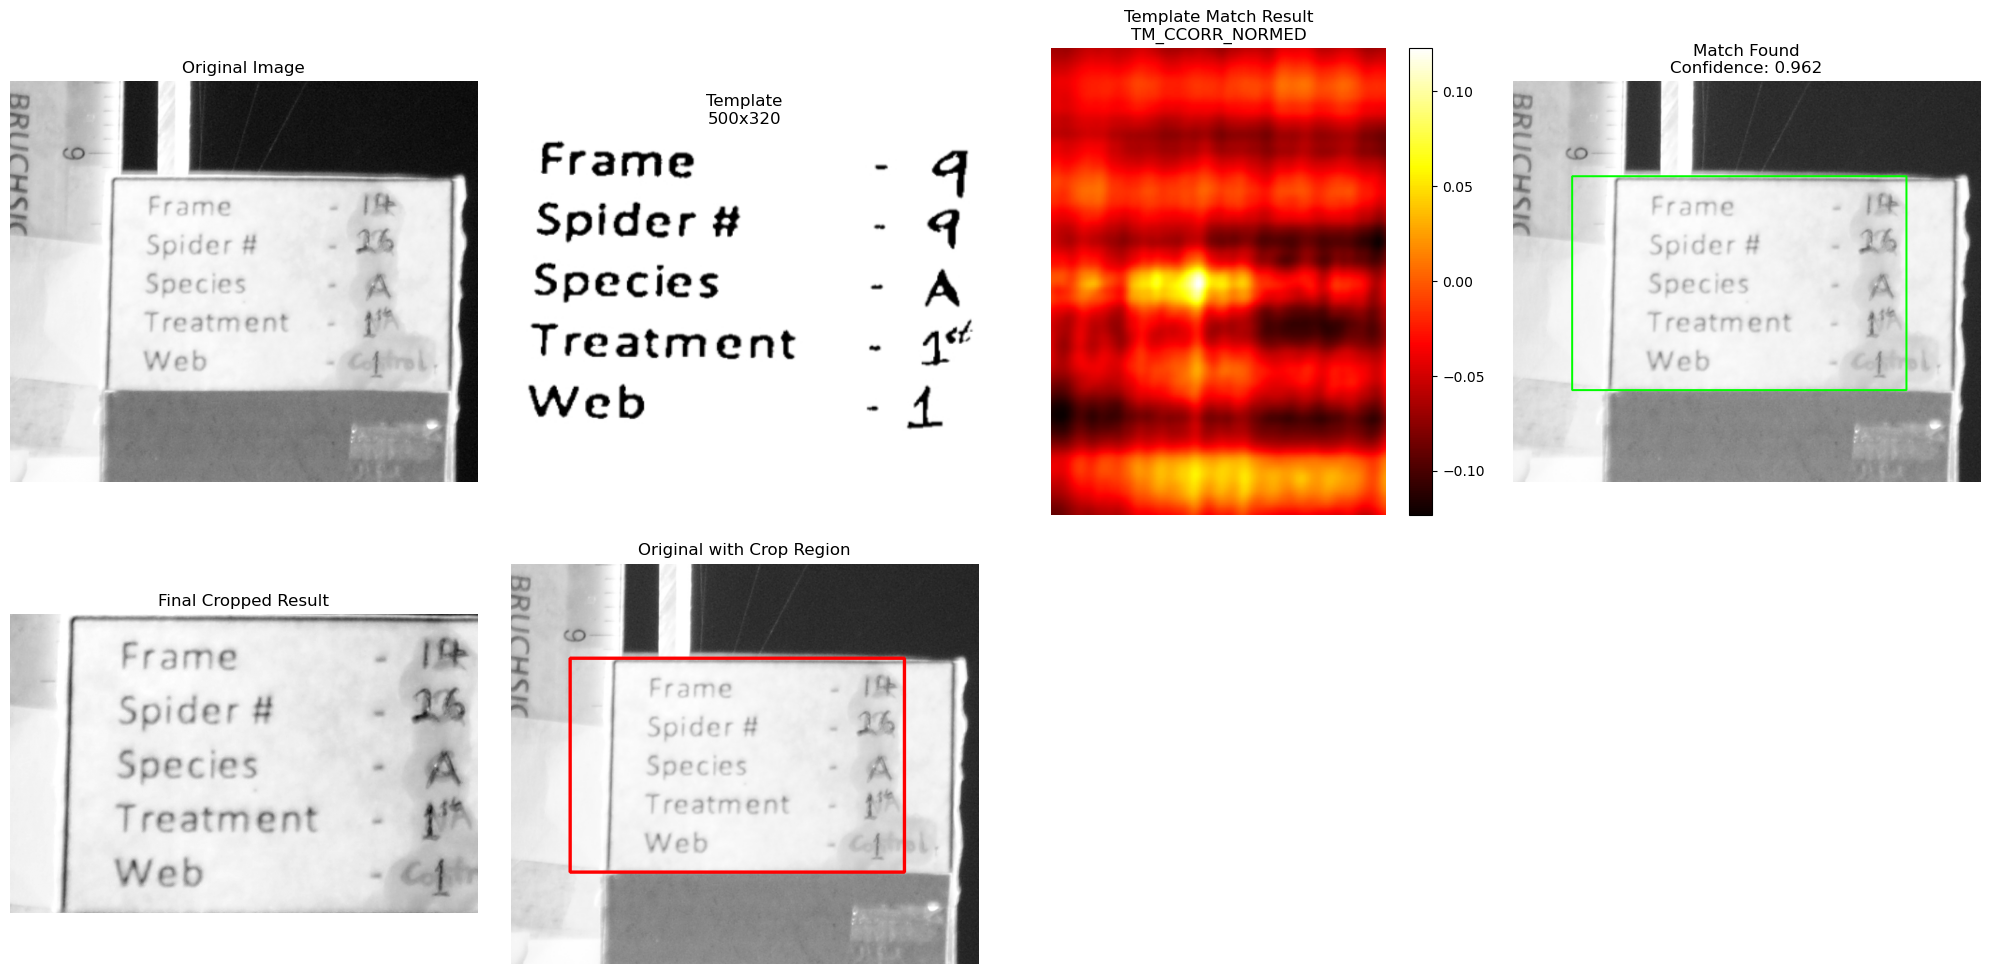

Original size: 700x600
Final crop coordinates: (88, 142) to (588, 462)
Cropped size: 500x320


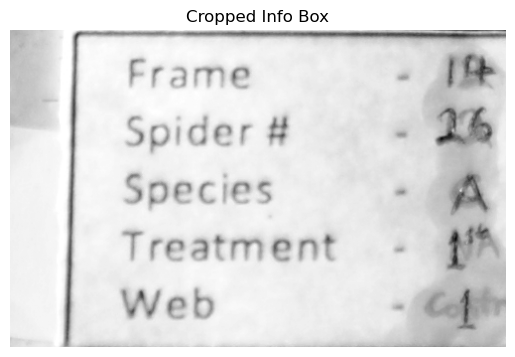

In [43]:
#Maybe try updating the template matching function to make a box of the same size. It always should be around 500x300
croptemplate_img = cv2.imread(r"C:\Files\Araneus diadematus\Processed Images\template-cropped.png")
croptemplate = cv2.resize(croptemplate_img, (500, 320))
data = crop_to_text_region(cropped_image, croptemplate)
plt.imshow(data, cmap='gray')
plt.title("Cropped Info Box")
plt.axis('off')
plt.show()

Template matching - Method: TM_CCORR_NORMED, Confidence: 0.952
Match location: (17, 0)


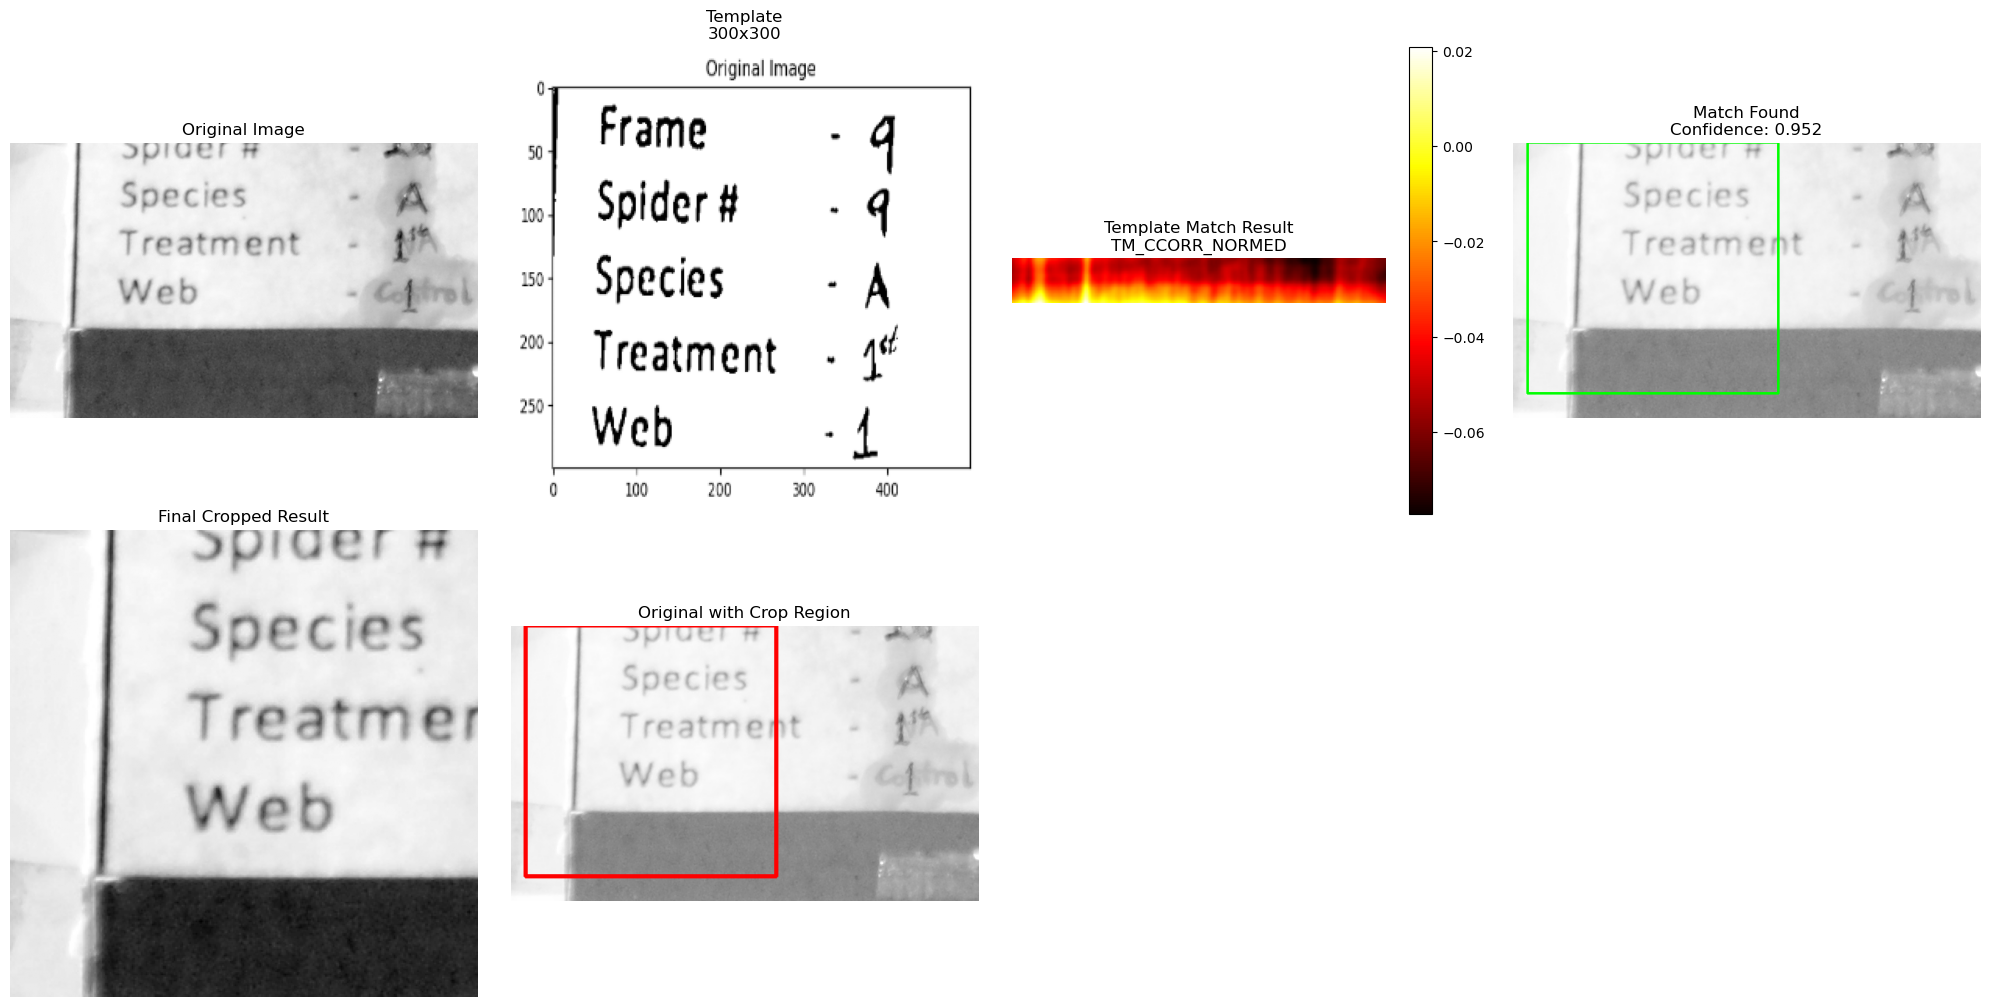

Original size: 560x330
Final crop coordinates: (17, 0) to (317, 300)
Cropped size: 300x300


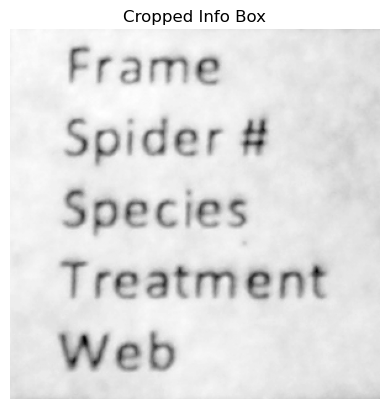

In [ ]:
#Maybe try updating the template matching function to make a box of the same size. It always should be around 300x300
template_img2 = cv2.imread(r"C:\Files\Araneus diadematus\Processed Images\template2.png")
template2 = cv2.resize(template_img2, (300, 300))
data2 = crop_to_text_region(cropped_image, template2)
plt.imshow(data, cmap='gray')
plt.title("Cropped Info Box")
plt.axis('off')
plt.show()

In [291]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def crop_to_text_region(img, output_path=None, show_steps=False):
    """
    Crop an image to focus on the main text/data region, excluding rulers and peripheral elements.
    Uses a bottom-up approach to find the main data table area.
    
    Args:
        img: Input image as numpy.ndarray (can be grayscale or color)
        output_path: Path to save the cropped image (optional)
        show_steps: Whether to display intermediate processing steps
    
    Returns:
        Cropped image as numpy array (same format as input)
    """
    
    # Validate input
    if not isinstance(img, np.ndarray):
        raise ValueError("Input must be a numpy.ndarray")
    
    # Handle both grayscale and color images
    if len(img.shape) == 2:
        is_grayscale = True
        original = img.copy()
        gray = img.copy()
    elif len(img.shape) == 3 and img.shape[2] == 3:
        is_grayscale = False
        original = img.copy()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Input image must be either grayscale (2D) or 3-channel color image")
    
    height, width = gray.shape
    
    if show_steps:
        plt.figure(figsize=(20, 15))
        plt.subplot(3, 4, 1)
        if is_grayscale:
            plt.imshow(original, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')
    
    # Apply binary threshold
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Check if we need to invert (text should be black on white background)
    if np.sum(thresh == 0) < np.sum(thresh == 255) * 0.3:  # If very little black, invert
        thresh = cv2.bitwise_not(thresh)
    
    if show_steps:
        plt.subplot(3, 4, 2)
        plt.imshow(thresh, cmap='gray')
        plt.title('Binary Threshold')
        plt.axis('off')
    
    # Strategy: Look for the main text block by analyzing horizontal text density
    # Scan from bottom up to find the main data area (avoiding ruler at top)
    
    # Calculate horizontal text density for each row
    row_densities = []
    for y in range(height):
        black_pixels = np.sum(thresh[y, :] == 0)  # Count black pixels (text)
        density = black_pixels / width
        row_densities.append(density)
    
    row_densities = np.array(row_densities)
    
    if show_steps:
        plt.subplot(3, 4, 3)
        plt.plot(row_densities)
        plt.title('Row Text Density')
        plt.xlabel('Row (Y coordinate)')
        plt.ylabel('Text Density')
        plt.gca().invert_xaxis()  # Invert to match image coordinates
    
    # Find the region with consistently high text density (the main data area)
    # Use a moving average to smooth the density curve
    window_size = max(5, height // 50)
    smoothed_density = np.convolve(row_densities, np.ones(window_size)/window_size, mode='same')
    
    # Find the range where text density is significant
    density_threshold = np.mean(smoothed_density) + 0.5 * np.std(smoothed_density)
    significant_rows = smoothed_density > density_threshold
    
    if show_steps:
        plt.subplot(3, 4, 4)
        plt.plot(row_densities, label='Original', alpha=0.7)
        plt.plot(smoothed_density, label='Smoothed', linewidth=2)
        plt.axhline(y=density_threshold, color='r', linestyle='--', label='Threshold')
        plt.title('Smoothed Row Density')
        plt.xlabel('Row (Y coordinate)')
        plt.ylabel('Text Density')
        plt.legend()
        plt.gca().invert_xaxis()
    
    # Find the largest continuous block of significant text density
    # This should correspond to the main data table
    if np.any(significant_rows):
        # Find continuous regions
        diff = np.diff(np.concatenate(([False], significant_rows, [False])).astype(int))
        starts = np.where(diff == 1)[0]
        ends = np.where(diff == -1)[0]
        
        # Find the largest continuous region
        largest_region_size = 0
        best_start, best_end = 0, height - 1
        
        for start, end in zip(starts, ends):
            region_size = end - start
            if region_size > largest_region_size:
                largest_region_size = region_size
                best_start, best_end = start, end
        
        # Prefer regions in the lower 2/3 of the image (avoid ruler at top)
        lower_third_start = height // 3
        for start, end in zip(starts, ends):
            if start >= lower_third_start:  # Prioritize regions in lower part
                region_size = end - start
                if region_size > largest_region_size * 0.7:  # Accept if reasonably large
                    best_start, best_end = start, end
                    break
        
        y_min, y_max = best_start, best_end
    else:
        # Fallback: use bottom 60% of image
        y_min = int(height * 0.4)
        y_max = height - 1
    
    # Now find horizontal bounds within this vertical region
    text_region = thresh[y_min:y_max, :]
    
    # Calculate vertical text density for each column within the identified region
    col_densities = []
    for x in range(width):
        black_pixels = np.sum(text_region[:, x] == 0)
        density = black_pixels / (y_max - y_min) if (y_max - y_min) > 0 else 0
        col_densities.append(density)
    
    col_densities = np.array(col_densities)
    
    if show_steps:
        plt.subplot(3, 4, 5)
        plt.plot(col_densities)
        plt.title('Column Text Density (in selected rows)')
        plt.xlabel('Column (X coordinate)')
        plt.ylabel('Text Density')
    
    # Find horizontal bounds
    col_threshold = np.mean(col_densities) * 0.3  # Lower threshold for columns
    significant_cols = col_densities > col_threshold
    
    if np.any(significant_cols):
        x_coords = np.where(significant_cols)[0]
        x_min, x_max = x_coords[0], x_coords[-1]
    else:
        # Fallback: use middle 80% of image width
        x_min = int(width * 0.1)
        x_max = int(width * 0.9)
    
    if show_steps:
        plt.subplot(3, 4, 6)
        region_highlight = thresh.copy()
        region_highlight = cv2.cvtColor(region_highlight, cv2.COLOR_GRAY2RGB)
        # Highlight the detected region
        region_highlight[y_min:y_max, x_min:x_max, 1] = 255  # Green channel
        plt.imshow(region_highlight)
        plt.title('Detected Text Region')
        plt.axis('off')
    
    # Add reasonable padding
    padding_x = min(30, max(10, int((x_max - x_min) * 0.05)))
    padding_y = min(20, max(8, int((y_max - y_min) * 0.05)))
    
    # Calculate final crop coordinates with padding
    crop_x1 = max(0, int(x_min - padding_x))
    crop_y1 = max(0, int(y_min - padding_y))
    crop_x2 = min(width, int(x_max + padding_x))
    crop_y2 = min(height, int(y_max + padding_y))
    
    # Ensure minimum crop size
    min_width, min_height = 100, 80
    crop_width = crop_x2 - crop_x1
    crop_height = crop_y2 - crop_y1
    
    if crop_width < min_width:
        center_x = (crop_x1 + crop_x2) // 2
        crop_x1 = max(0, center_x - min_width // 2)
        crop_x2 = min(width, crop_x1 + min_width)
    
    if crop_height < min_height:
        center_y = (crop_y1 + crop_y2) // 2
        crop_y1 = max(0, center_y - min_height // 2)
        crop_y2 = min(height, crop_y1 + min_height)
    
    # Crop the image
    cropped = original[crop_y1:crop_y2, crop_x1:crop_x2]
    
    if show_steps:
        plt.subplot(3, 4, 7)
        if is_grayscale:
            plt.imshow(cropped, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        plt.title('Final Cropped Result')
        plt.axis('off')
        
        # Show crop region overlay on original
        plt.subplot(3, 4, 8)
        overlay = original.copy()
        if not is_grayscale:
            overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
        else:
            overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2RGB)
        
        # Draw crop rectangle
        cv2.rectangle(overlay, (crop_x1, crop_y1), (crop_x2, crop_y2), (255, 0, 0), 3)
        plt.imshow(overlay)
        plt.title('Final Crop Region (Red Box)')
        plt.axis('off')
        
        # Show the significant rows visualization
        plt.subplot(3, 4, 9)
        row_viz = np.zeros((height, 50, 3), dtype=np.uint8)
        for i, is_sig in enumerate(significant_rows):
            if is_sig:
                row_viz[i, :] = [0, 255, 0]  # Green for significant rows
            else:
                row_viz[i, :] = [100, 100, 100]  # Gray for non-significant
        
        # Highlight the selected region
        row_viz[y_min:y_max, :] = [255, 0, 0]  # Red for selected region
        plt.imshow(row_viz)
        plt.title('Row Selection\n(Green=significant, Red=selected)')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Original size: {width}x{height}")
        print(f"Detected text region: Y({y_min}-{y_max}), X({x_min}-{x_max})")
        print(f"Final crop coordinates: ({crop_x1}, {crop_y1}) to ({crop_x2}, {crop_y2})")
        print(f"Cropped size: {crop_x2-crop_x1}x{crop_y2-crop_y1}")
        print(f"Density threshold: {density_threshold:.4f}")
    
    if output_path:
        cv2.imwrite(output_path, cropped)
        print(f"Cropped image saved to {output_path}")
    
    return cropped

def center_crop(img, scale=0.6):
    """
    Fallback: crop the center portion of the image.
    """
    if len(img.shape) == 2:
        h, w = img.shape
    else:
        h, w = img.shape[:2]
    
    crop_h = int(h * scale)
    crop_w = int(w * scale)
    
    start_y = (h - crop_h) // 2
    start_x = (w - crop_w) // 2
    
    return img[start_y:start_y + crop_h, start_x:start_x + crop_w]

def crop_with_manual_box(img, x1, y1, x2, y2):
    """
    Crop image with manually specified coordinates.
    Useful if you know the approximate location of your text.
    
    Args:
        img: Input image
        x1, y1: Top-left corner
        x2, y2: Bottom-right corner
    """
    return img[y1:y2, x1:x2]

def batch_crop_images(images, output_dir="cropped_images", image_names=None):
    """
    Crop multiple images in batch.
    
    Args:
        images: List of numpy.ndarray images
        output_dir: Directory to save cropped images
        image_names: Optional list of names for the images (without extension)
    """
    import os
    
    os.makedirs(output_dir, exist_ok=True)
    
    for i, img in enumerate(images):
        try:
            if image_names and i < len(image_names):
                filename = f"{image_names[i]}.jpg"
            else:
                filename = f"cropped_{i+1}.jpg"
            
            output_path = os.path.join(output_dir, filename)
            cropped = crop_to_text_region(img, output_path)
            print(f"Successfully processed image {i+1}")
        except Exception as e:
            print(f"Error processing image {i+1}: {str(e)}")

def load_image_from_path(image_path):
    """
    Helper function to load an image from file path.
    
    Args:
        image_path: Path to the image file
        
    Returns:
        Image as numpy.ndarray in BGR format
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image from {image_path}")
    return img



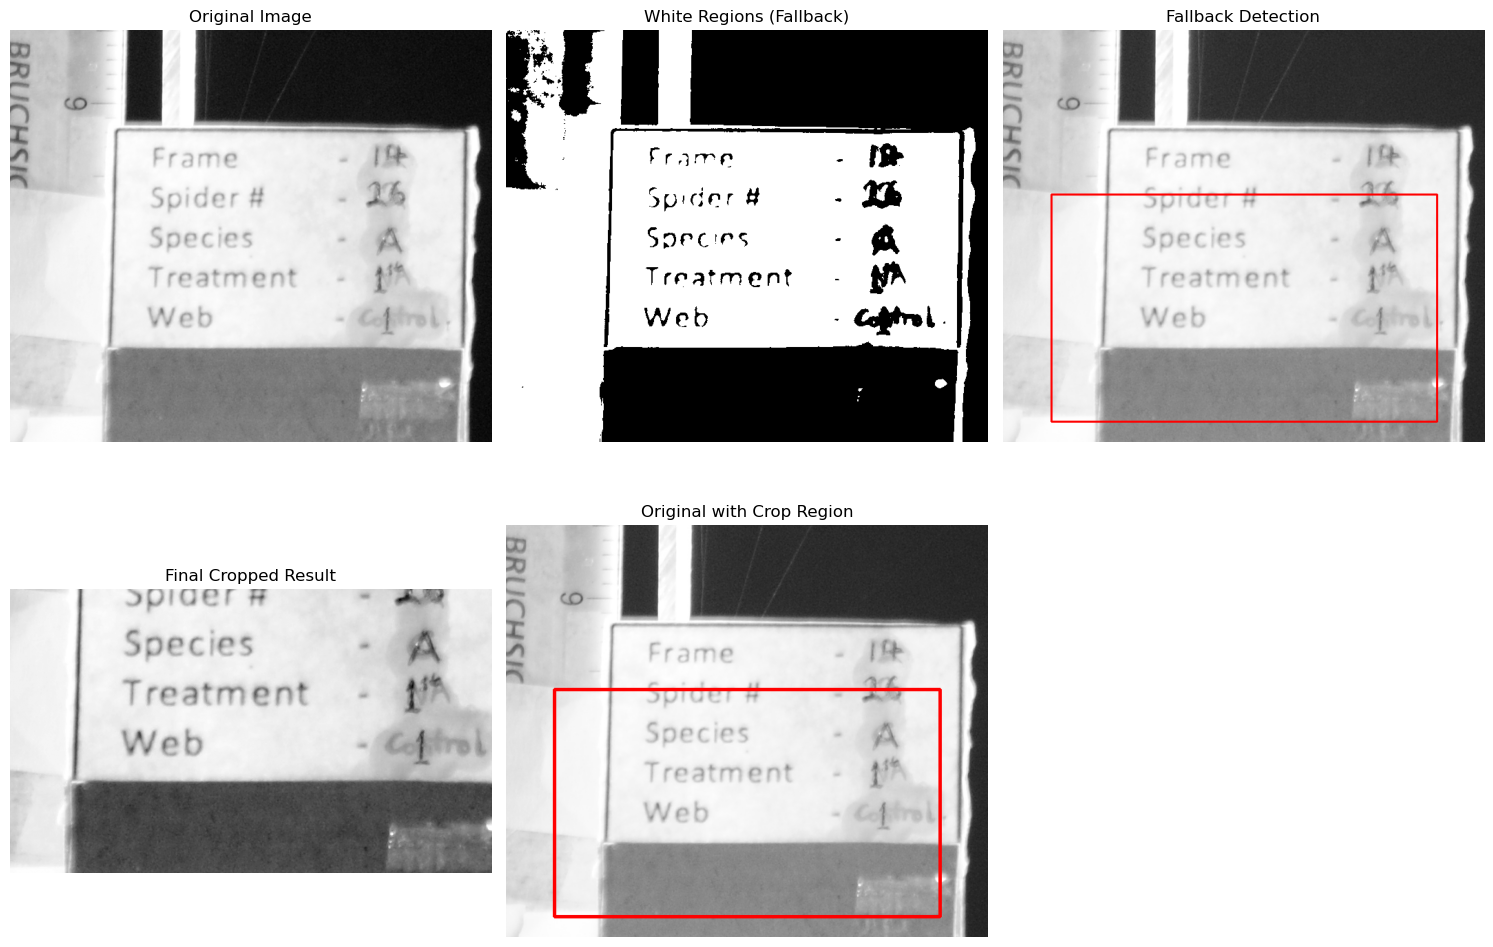

Original size: 700x600
Final crop coordinates: (70, 240) to (630, 570)
Cropped size: 560x330


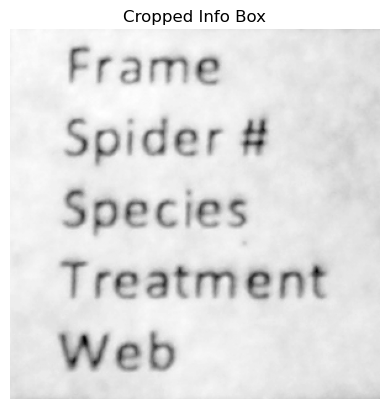

In [ ]:
cropped_image = crop_to_text_region(cropped_image)
plt.imshow(cropped_image, cmap='gray')
plt.title("Cropped Info Box")
plt.axis('off')
plt.show()


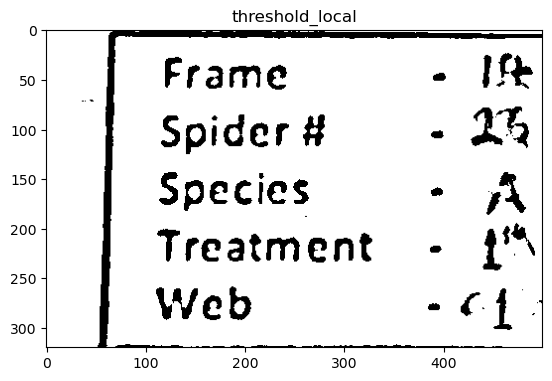

In [44]:
# We get the Value component from the HSV color space. 
# then we apply adaptive thresholding to
from skimage.filters import threshold_local
color_image = cv2.cvtColor(data, cv2.COLOR_GRAY2BGR)
hsv_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2HSV)
Values = cv2.split(hsv_image)[2]
Threshold = threshold_local(Values, 25, offset=15, method="median")
# Apply the threshold operation
thresh = (Values > Threshold).astype("uint8") * 255 #image to display with threshold editing done to it. changes all values to either black (0) if below threshold or white (255) if above threshold 
imshow("threshold_local", thresh)



In [200]:
#save reader_image to a folder so I can give it to AI
cv2.imwrite("C:\Files\Araneus diadematus\Processed Images\processed.jpg", thresh)

True

In [45]:
#Function to break an image into lines so that it simple htr can read it well
import cv2
import numpy as np
from sklearn.cluster import AgglomerativeClustering
# def segment_lines(img, pad_x=30, pad_y=5, expected_lines=5, min_line_height=10, resize_height=64):
#     if len(img.shape) == 3:
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#     # Binarize and invert
#     binary = cv2.adaptiveThreshold(
#         img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
#         cv2.THRESH_BINARY_INV, 25, 15)

#     # Horizontal projection
#     projection = np.sum(binary, axis=1)
#     threshold = np.max(projection) * 0.1

#     # Detect y ranges based on projection valleys
#     y_ranges = []
#     start = None
#     for y, val in enumerate(projection):
#         if val > threshold and start is None:
#             start = y
#         elif val <= threshold and start is not None:
#             if y - start > min_line_height:
#                 y_ranges.append((max(start - pad_y, 0), min(y + pad_y, img.shape[0])))
#             start = None
#     if start is not None:
#         y_ranges.append((max(start - pad_y, 0), img.shape[0]))

#     # Find contours to compute horizontal span
#     contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     boxes = [cv2.boundingRect(c) for c in contours]

#     line_imgs = []
#     for y1, y2 in y_ranges:
#         boxes_in_range = [b for b in boxes if (b[1] < y2 and (b[1] + b[3]) > y1)]
#         if not boxes_in_range:
#             continue

#         extra_pad_x = 20  # extra width on left and right
#         extra_pad_y = 10  # extra height above and below

#         x1 = max(min([b[0] for b in boxes_in_range]) - pad_x - extra_pad_x, 0)
#         x2 = min(max([b[0] + b[2] for b in boxes_in_range]) + pad_x + extra_pad_x, img.shape[1])
#         y1 = max(y1 - extra_pad_y, 0)
#         y2 = min(y2 + extra_pad_y, img.shape[0])

#         line_crop = img[y1:y2, x1:x2]

#         # Resize to uniform height, preserving aspect ratio
#         if resize_height is not None:
#             h, w = line_crop.shape
#             scale = resize_height / h
#             new_w = int(w * scale)
#             line_crop = cv2.resize(line_crop, (new_w, resize_height), interpolation=cv2.INTER_LINEAR)

#         line_imgs.append(line_crop)

#     if len(line_imgs) > expected_lines:
#         line_imgs = line_imgs[-expected_lines:]
#     elif len(line_imgs) < expected_lines:
#         raise ValueError(f"Expected {expected_lines} lines, but found {len(line_imgs)}.")

#     return line_imgs
def segment_lines(img, expected_lines=5, line_height=80, resize_height=64):
    """
    Segments an image into a fixed number of horizontal lines.
    Uses morphological filtering and fallback to uniform slicing.
    """
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Normalize size (helps standardize detection)
    target_height = expected_lines * line_height
    scale = target_height / img.shape[0]
    img_resized = cv2.resize(img, (int(img.shape[1] * scale), target_height), interpolation=cv2.INTER_LINEAR)

    # Apply morphological close to unify text lines
    blur = cv2.GaussianBlur(img_resized, (5, 5), 0)
    _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(img_resized.shape[1] * 0.5), 5))
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    line_boxes = [cv2.boundingRect(c) for c in contours]
    line_boxes = sorted(line_boxes, key=lambda b: b[1])  # sort top to bottom

    line_imgs = []
    for box in line_boxes:
        x, y, w, h = box
        if h < 20:  # filter out small blobs
            continue
        line = img_resized[y:y+h, x:x+w]
        if resize_height is not None:
            scale = resize_height / line.shape[0]
            new_w = int(line.shape[1] * scale)
            line = cv2.resize(line, (new_w, resize_height), interpolation=cv2.INTER_LINEAR)
        line_imgs.append(line)

    # If line detection failed or count doesn't match, fallback to fixed slicing
    if len(line_imgs) != expected_lines:
        h = img_resized.shape[0]
        slice_height = h // expected_lines
        line_imgs = [
            cv2.resize(img_resized[i*slice_height:(i+1)*slice_height], (img_resized.shape[1], resize_height))
            for i in range(expected_lines)
        ]

    return line_imgs







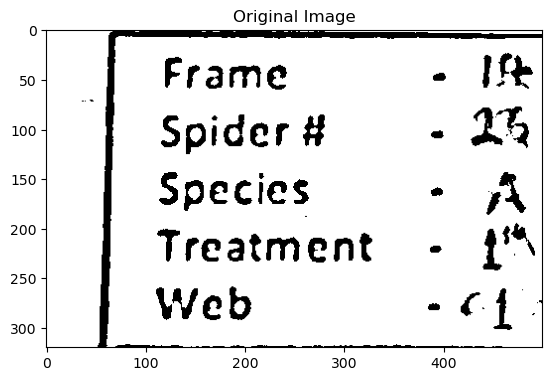

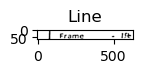

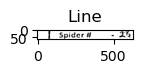

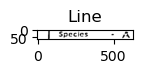

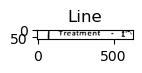

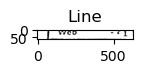

In [46]:
imshow("Original Image", thresh)
lines = segment_lines(thresh) #returns a list of images of each line
for i in lines:
    linenum = 1
    imshow("Line", i, size = 12)
    linenum += 1

In [ ]:
import re
import cv2
import torch
import numpy as np
from difflib import get_close_matches
from easyocr import Reader
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import pytesseract

# Known labels
KNOWN_LABELS = ['Frame', 'Spider #', 'Species', 'Treatment', 'Web']

def correct_easy_label(label):
    match = get_close_matches(label, KNOWN_LABELS, n=1, cutoff=0.7)
    return match[0] if match else label

def clean_trocr_output(text):
    text = (
        text.replace('1/', '1st')
            .replace('0-1', '1')
            .replace('- -', '-')
            .replace('--', '-')
            .replace('  ', ' ')
    )
    text = re.sub(r'-\s*q\b', '- 9', text)
    text = re.sub(r'_(\d)', r'-\1', text)
    return text.strip()

def clean_repeated_tokens(text):
    tokens = text.split()
    cleaned_tokens = []
    for i, token in enumerate(tokens):
        if i > 0 and token == tokens[i - 1]:
            continue
        cleaned_tokens.append(token)
    return ' '.join(cleaned_tokens)

def extract_trailing_digits_with_tesseract(image):
    config = "--psm 7 -c tessedit_char_whitelist=0123456789"
    text = pytesseract.image_to_string(image, config=config)
    digits = re.findall(r'\d+', text)
    return digits[-1] if digits else ""

def standardize_label_format(label, value):
    label = correct_easy_label(label)
    if 'spider' in label.lower():
        return f"{label} - {value}"
    if 'web' in label.lower():
        return f"{label} # {value}"
    return f"{label} - {value}"

# def hybrid_ocr(lines):
#     easy_reader = Reader(['en'], gpu=False)
#     trocr_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
#     trocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

#     all_results = []

#     for line_idx, line_image in enumerate(lines):
#         print(f"\n--- Processing Line {line_idx + 1} ---")

#         if len(line_image.shape) == 2:
#             gray = line_image
#         else:
#             gray = cv2.cvtColor(line_image, cv2.COLOR_BGR2GRAY)

#         # Preprocessing: sharpen + threshold + resize
#         blurred = cv2.GaussianBlur(gray, (0, 0), 3)
#         sharpened = cv2.addWeighted(gray, 1.5, blurred, -0.5, 0)
#         _, thresh = cv2.threshold(sharpened, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#         resized = cv2.resize(thresh, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)

#         # EasyOCR: get label
#         reader_image = cv2.cvtColor(resized, cv2.COLOR_GRAY2BGR)
#         easy_results = easy_reader.readtext(reader_image)
#         easy_text = [text for (_, text, prob) in easy_results if prob > 0.5]
#         easy_text = [correct_easy_label(t) for t in easy_text]
#         easy_line_text = " ".join(easy_text)

#         label = ""
#         for t in easy_text:
#             match = get_close_matches(t, KNOWN_LABELS, cutoff=0.7)
#             if match:
#                 label = match[0]
#                 break

#         # TrOCR: full line
#         pil_image = Image.fromarray(resized).convert("RGB")
#         pixel_values = trocr_processor(pil_image, return_tensors="pt").pixel_values
#         with torch.no_grad():
#             generated_ids = trocr_model.generate(pixel_values)
#         trocr_text = trocr_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
#         trocr_text = clean_trocr_output(trocr_text)
#         trocr_text = clean_repeated_tokens(trocr_text)

#         # Remove known label from trocr_text to extract value
#         value = trocr_text
#         if label:
#             pattern = re.escape(label)
#             match = re.search(pattern + r"[:\-#\s]*", value, re.IGNORECASE)
#             if match:
#                 value = value[match.end():].strip()

#         # Fallback for Spider #
#         if label.lower() == "spider #" and not re.search(r'\d+', value):
#             digit = extract_trailing_digits_with_tesseract(resized)
#             if digit and len(digit) <= 2:
#                 value = digit

#         # Final line
#         final_line = standardize_label_format(label, value)

#         result = {
#             'line_idx': line_idx,
#             'label': label,
#             'value': value,
#             'final_text': final_line
#         }

#         all_results.append(result)
#         print(f"EasyOCR Label: {label}")
#         print(f"TrOCR Raw: {trocr_text}")
#         print(f"Final Combined: {final_line}")

#     return [res['final_text'] for res in all_results]



    
def hybrid_ocr_by_index_cropped(lines):
    from transformers import TrOCRProcessor, VisionEncoderDecoderModel
    from PIL import Image

    KNOWN_LABELS = ['Frame', 'Spider #', 'Species', 'Treatment', 'Web']

    trocr_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
    trocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

    def clean_text(t):
        t = t.replace('--', '-').replace('  ', ' ')
        t = re.sub(r'[_–]+', '-', t)
        return t.strip(" .:")

    def crop_value_area(img):
        h, w = img.shape[:2]
        crop_start_x = int(w * 0.35)  # adjust this % if needed
        return img[:, crop_start_x:]

    final_results = []

    for i, line in enumerate(lines):
        label = KNOWN_LABELS[i] if i < len(KNOWN_LABELS) else f"Field{i+1}"

        gray = cv2.cvtColor(line, cv2.COLOR_BGR2GRAY) if len(line.shape) == 3 else line
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        cropped_value = crop_value_area(binary)

        # Resize for better OCR performance
        scaled = cv2.resize(cropped_value, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)

        # TrOCR
        pil_image = Image.fromarray(scaled).convert("RGB")
        pixel_values = trocr_processor(pil_image, return_tensors="pt").pixel_values
        with torch.no_grad():
            output_ids = trocr_model.generate(pixel_values)
        decoded_text = trocr_processor.batch_decode(output_ids, skip_special_tokens=True)[0]

        cleaned_value = clean_text(decoded_text)
        final_results.append(f"{label} - {cleaned_value}")

    return final_results








In [48]:
def crop_line_values(lines, crop_ratio=0.6, margin=10):
    """
    Crop each line image to focus only on the right-side value content.

    Args:
        lines (list of np.ndarray): List of line images.
        crop_ratio (float): Fraction of image width to skip (left side).
        margin (int): Padding added to right-side content for OCR.

    Returns:
        list of np.ndarray: Cropped line images containing only the value part.
    """
    cropped_values = []

    for idx, line in enumerate(lines):
        h, w = line.shape[:2]
        start_x = int(w * crop_ratio)
        end_x = w

        # Slightly expand the region if possible
        cropped = line[:, start_x:end_x]
        if margin > 0:
            pad_left = min(start_x, margin)
            cropped = line[:, start_x - pad_left:end_x]

        cropped_values.append(cropped)

    return cropped_values


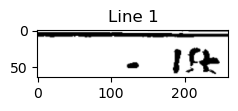

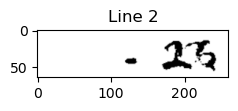

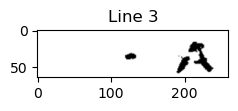

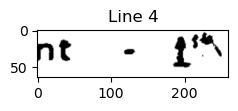

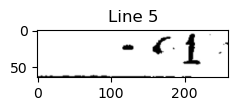

In [61]:
spider_info = crop_line_values(lines)
linenum = 1
for i in spider_info:
    imshow("Line " + str(linenum), i)
    cv2.imwrite("C:\Files\Araneus diadematus\Processed Images\processed" + str(linenum) + ".jpg", i)
    linenum+=1


In [52]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import cv2
import numpy as np
import torch
import re

# Load TrOCR once
trocr_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
trocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

def preprocess_cropped(image):
    # Convert to grayscale if not already
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    # Resize (upscale)
    resized = cv2.resize(gray, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)

    # Contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4,4))
    enhanced = clahe.apply(resized)

    # Sharpening kernel
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(enhanced, -1, kernel)

    return sharpened

def clean_cropped_trocr_output(text):
    text = text.strip()
    text = re.sub(r'[^\w\s%]+', '', text)  # remove stray punctuation
    text = re.sub(r'\s+', '', text)        # remove inner spaces

    # Remove leading zero if it's a single-digit number
    text = re.sub(r'^0(?=\d$)', '', text)

    # Collapse repeated letters (only for alpha)
    if text.isalpha():
        text = re.sub(r'(.)\1+', r'\1', text)

    # Remove ordinal suffixes from digits (if any)
    text = re.sub(r'(\d+)(st|nd|rd|th)$', r'\1', text, flags=re.IGNORECASE)

    return text


def ocr_cropped_images(image_list):
    results = []
    for idx, img in enumerate(image_list):
        processed = preprocess_cropped(img)
        pil_image = Image.fromarray(processed).convert("RGB")
        pixel_values = trocr_processor(pil_image, return_tensors="pt").pixel_values

        with torch.no_grad():
            generated_ids = trocr_model.generate(pixel_values)
        text = trocr_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        cleaned = clean_cropped_trocr_output(text)

        results.append(cleaned)
        print(f"Cropped {idx+1}: {cleaned}")

    return results


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
ocr_cropped_images(spider_info)

Cropped 1: 61
Cropped 2: 013
Cropped 3: 0A
Cropped 4: nt1m
Cropped 5: c1


['61', '013', '0A', 'nt1m', 'c1']

In [67]:
import cv2
import numpy as np
from PIL import Image
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# Load TrOCR model once
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

# Updated preprocessing to reduce damage to sparse characters
def preprocess_value_image(image):
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    h, w = gray.shape
    cropped = gray[:, int(w * 0.1):]  # Keep 90% of the image

    # Threshold
    _, binary = cv2.threshold(cropped, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Resize and pad to center the text
    resized = cv2.resize(binary, (256, 64), interpolation=cv2.INTER_NEAREST)
    padded = cv2.copyMakeBorder(resized, 16, 16, 16, 16, cv2.BORDER_CONSTANT, value=255)

    return padded

# Clean and standardize OCR text
def clean_ocr_text(text):
    if not text:
        return ""
    text = text.strip().upper()
    text = re.sub(r'(\d+)(ST|ND|RD|TH)\b', r'\1', text)
    text = re.sub(r'[^A-Z0-9]', '', text)
    return text



# def specialized_value_ocr(cv2_image_list):
#     """
#     Accepts a list of cropped OpenCV images and returns cleaned OCR strings.
#     """
#     results = []
#     for i, img in enumerate(cv2_image_list):
#         processed = preprocess_value_image(img)
#         raw_text = run_trocr_on_image(processed)
#         cleaned = clean_ocr_text(raw_text)
#         print(f"Cropped {i+1}: {cleaned}")
#         results.append(cleaned)
#     return results


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from difflib import SequenceMatcher
import easyocr

reader = easyocr.Reader(['en'], gpu=False)

EXPECTED_VALUES = {
    0: {'9', '3', '10', '14', '11', '16', '6', '7', '15', '1', '17', '19', '12', '13'},
    1: {'9', '19', '25', '26', '29', '32', '36', '39', '40', '41', '42', '43', '48', '49', '50', '56', '58'},
    2: {'A'},
    3: {'1ST', 'NA'},
    4: {'1', '2', '3', '4', '5', 'CONTROL', 'C'},
}

from difflib import SequenceMatcher

# Confusion fix map for heuristic matching
confusion_map = {
    'TIM': '1ST', '1M': '1ST', 'IM': '1ST', 'IST': '1ST', 'I5T': '1ST',
    '6': '14', 'G': '6', 'O': '0', 'C1': '1', 'CI': '1',
}

from difflib import SequenceMatcher

def clean_and_match(text, expected_set, index=None):
    if not text:
        return '', 0.0

    original = text
    text = clean_ocr_text(text)

    # Heuristics: fix common OCR confusions
    confusion_map = {
        'TIM': '1ST', '1M': '1ST', 'IM': '1ST', 'IST': '1ST',
        'C': 'CONTROL', 'O': '0', 'L': '1'
    }
    if text in confusion_map and confusion_map[text] in expected_set:
        return confusion_map[text], 1.0

    if index == 3:  # Line 4: ordinal logic
        text = re.sub(r'(1)([A-Z]{1,2})', '1ST', text)

    best_match = ''
    best_score = 0.0

    for candidate in expected_set:
        score = SequenceMatcher(None, text, candidate).ratio()

        # Penalize mismatched lengths in Line 1 slightly
        if index == 0 and abs(len(text) - len(candidate)) >= 1:
            score -= 0.1

        if score > best_score:
            best_match = candidate
            best_score = score

    threshold = 0.55 if index == 0 else 0.5
    return best_match if best_score >= threshold else f"Unmatched: {original}", best_score



def hybrid_ocr(cv2_image_list):
    results = []
    for i, img in enumerate(cv2_image_list):
        processed = preprocess_value_image(img)

        expected_set = EXPECTED_VALUES.get(i, set())

        # TrOCR prediction
        trocr_raw = run_trocr_on_image(processed)
        trocr_match, trocr_score = clean_and_match(trocr_raw, expected_set)

        # EasyOCR prediction
        easy_result = reader.readtext(processed, detail=0)
        easy_raw = easy_result[0] if easy_result else ''
        easy_match, easy_score = clean_and_match(easy_raw, expected_set)

        # Choose better score
        if trocr_score >= easy_score:
            final = trocr_match
        else:
            final = easy_match

        print(f"Line {i+1} => TrOCR: {trocr_match} ({trocr_score:.2f}), "
              f"EasyOCR: {easy_match} ({easy_score:.2f}) => Selected: {final}")
        results.append(final)

    return results




Using CPU. Note: This module is much faster with a GPU.


In [82]:
hybrid_ocr(spider_info)


TypeError: run_trocr_on_image() missing 2 required positional arguments: 'processor' and 'model'

Using CPU. Note: This module is much faster with a GPU.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Processing Line 1 ---


c:\Users\adamain\.conda\envs\imgid\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


EasyOCR Label: 
TrOCR Raw: cr #
Final Combined:  - cr #

--- Processing Line 2 ---
EasyOCR Label: 
TrOCR Raw: S.S.
Final Combined:  - S.S.

--- Processing Line 3 ---
EasyOCR Label: 
TrOCR Raw: nent -
Final Combined:  - nent -

--- Processing Line 4 ---
EasyOCR Label: 
TrOCR Raw: 0
Final Combined:  - 0

--- Processing Line 5 ---
EasyOCR Label: 
TrOCR Raw: Print export
Final Combined:  - Print export


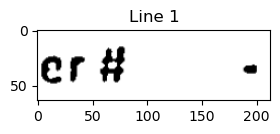

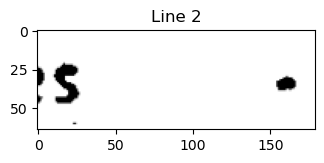

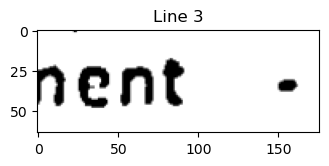

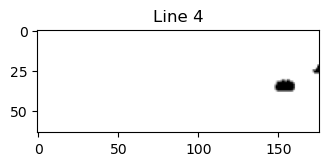

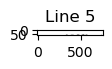

In [193]:
#Both trOCR (large-handwritten model) for handwriting and easyOCR for text

hybrid_ocr(spider_info)
linenum = 1
for i in spider_info:
    imshow("Line " + str(linenum), i)
    cv2.imwrite("C:\Files\Araneus diadematus\Processed Images\processed" + str(linenum) + ".jpg", i)
    linenum+=1